Please upload your HeartRate.csv file.


Saving HeartRateHRVtraining.csv to HeartRateHRVtraining (1).csv
Uploaded file: HeartRateHRVtraining (1).csv
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.9888
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8979
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7490
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6932
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6727
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6223
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6212
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6078
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5846
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5837
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5206
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5166
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4712
Epoch 14/50
25/25 ━━━━━━━━━━━

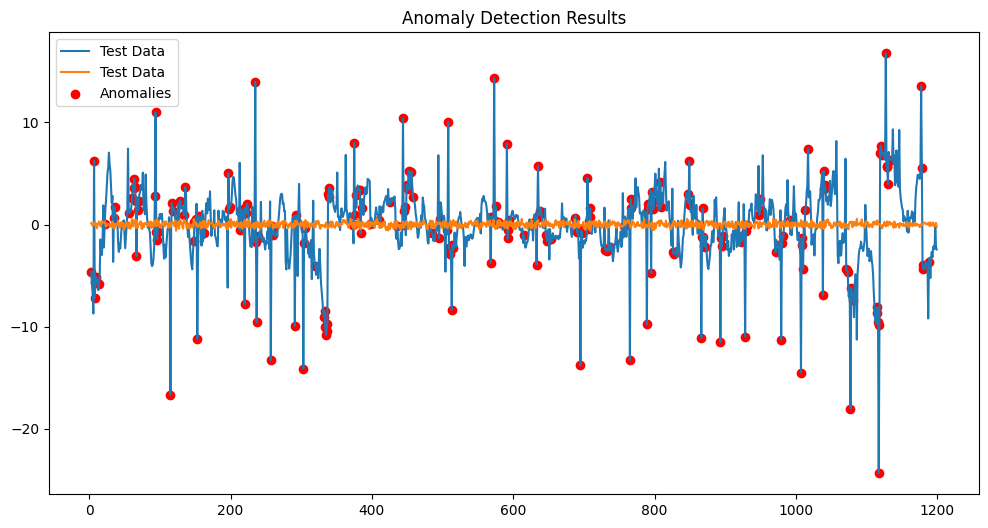

LSTM pipeline completed. Ready for Raspberry Pi deployment!


In [ ]:
# execute_v3.py do NOT EDIT - Full pipeline with file upload support (Google Colab or Jupyter)

import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files  # Only needed for Colab uploads
from statsmodels.tsa.seasonal import STL
import numpy as np

# Upload CSV file
print("Please upload your HeartRate.csv file.")
uploaded = files.upload()

# Auto-detect uploaded file name
uploaded_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {uploaded_filename}")

# Load data loader functions
def load_data(filepath):
    df = pd.read_csv(filepath)
    df = df[['Heartrate', 'HRV']]  # Select only the relevant columns for the model
    return df

def split_data(df, train_size):
    train = df.iloc[:train_size].copy()
    test = df.iloc[train_size:].copy()
    return train, test

def normalize_data(train, test):
    mean = train.mean()
    std = train.std()
    train_norm = (train - mean) / std
    test_norm = (test - mean) / std
    return mean, std, train_norm, test_norm

# Model and training functions
!pip install keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_model(input_shape, ext_units, int_units):
    inputs = Input(shape=input_shape)
    x = LSTM(ext_units, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(int_units, activation='relu')(x)
    x = RepeatVector(input_shape[0])(x)
    x = LSTM(int_units, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(ext_units, activation='relu', return_sequences=True)(x)
    outputs = TimeDistributed(Dense(input_shape[1]))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(model, train_data):
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    history = model.fit(train_data, train_data, epochs=50, batch_size=32, callbacks=[es], verbose=1)
    return history

def predict(model, test_data):
    return model.predict(test_data)

def calculate_error(true, pred):
    return ((true - pred) ** 2).mean(axis=(1, 2))

def detect_anomalies(errors, window_size=100, percentile=82):
    anomalies = []
    for i in range(len(errors)):
        start = max(0, i - window_size // 2)
        end = min(len(errors), i + window_size // 2)
        local_errors = errors[start:end]
        local_threshold = np.percentile(local_errors, percentile)  # Adaptive percentile-based threshold
        if errors[i] > local_threshold:
            anomalies.append(i)
    print(f"Detected {len(anomalies)} anomalies (adaptive threshold based on {percentile}th percentile)")
    return anomalies

def convert_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Fix 1: Enable Select TF Ops to support complex ops like LSTM
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    # Fix 2: Disable experimental lowering of tensor list ops
    converter._experimental_lower_tensor_list_ops = False
    # Fix 3: Enable resource variable support
    converter.experimental_enable_resource_variables = True

    tflite_model = converter.convert()

    with open("lstm_autoencoder.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model converted and saved as lstm_autoencoder.tflite")


# Constants
TRAIN_SIZE = 800
EXT_LSTM_UNITS = 128
INT_LSTM_UNITS = 64

# Load and preprocess data
df = load_data(uploaded_filename)

# Preprocess for stationarity using STL decomposition
stl_sensor1 = STL(df['Heartrate'], period=60).fit()
stl_sensor2 = STL(df['HRV'], period=60).fit()
df['Heartrate'] = stl_sensor1.resid  # Use residuals
df['HRV'] = stl_sensor2.resid

train_data, test_data = split_data(df, TRAIN_SIZE)

# Check for constant features
if train_data.std(axis=0).min() == 0:
    print("Warning: One or more features have zero standard deviation. Normalization may fail.")

mean, std, train_data, test_data = normalize_data(train_data, test_data)

# After normalize_data
window_size = 4
def reshape_with_windows(data, window_size):
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i+window_size])
    return np.array(X)

train_data = reshape_with_windows(train_data.values, window_size)
test_data = reshape_with_windows(test_data.values, window_size)
INPUT_SHAPE = (train_data.shape[1], train_data.shape[2])  # (10, 2)

# Build and train model
model = build_model(INPUT_SHAPE, EXT_LSTM_UNITS, INT_LSTM_UNITS)
history = train_model(model, train_data)

# Save and convert model
model.save("lstm_autoencoder.keras")

print("Model saved as lstm_autoencoder.h5")
convert_to_tflite(model)

# Predict and detect anomalies
test_predictions = predict(model, test_data)
mse = calculate_error(test_data, test_predictions)
anomalies = detect_anomalies(mse)

# Plot results - Adjusted for windowed data
test_df = df.iloc[TRAIN_SIZE:].reset_index(drop=True)
plot_start_idx = window_size - 1  # Skip initial partial windows
plt.figure(figsize=(12, 6))
plt.plot(test_df.iloc[plot_start_idx:], label='Test Data')  # Plot from the first full window
# Map anomalies back to original indices, adjusting for window start
original_anomaly_indices = [i + window_size - 1 for i in anomalies]  # Center of the window
plt.scatter(original_anomaly_indices, test_df.iloc[original_anomaly_indices, 0], color='red', label='Anomalies')
plt.title("Anomaly Detection Results")
plt.legend()
plt.show()



Detected 28 anomalies (adaptive 82th percentile)
Anomaly indices (original CSV rows): [29, 41, 47, 48, 50, 53, 61, 69, 72, 79, 80, 82, 88, 89, 91, 92, 93, 96, 131, 136, 137, 138, 140, 141, 144, 145, 197, 198]
Saved → HeartRate_Analyzed.csv


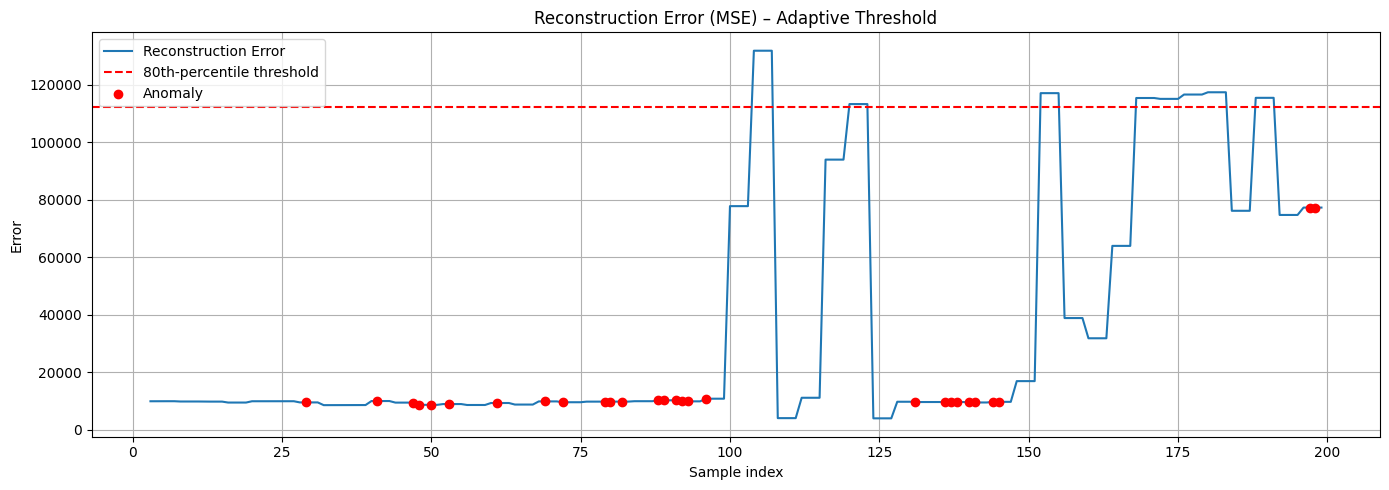

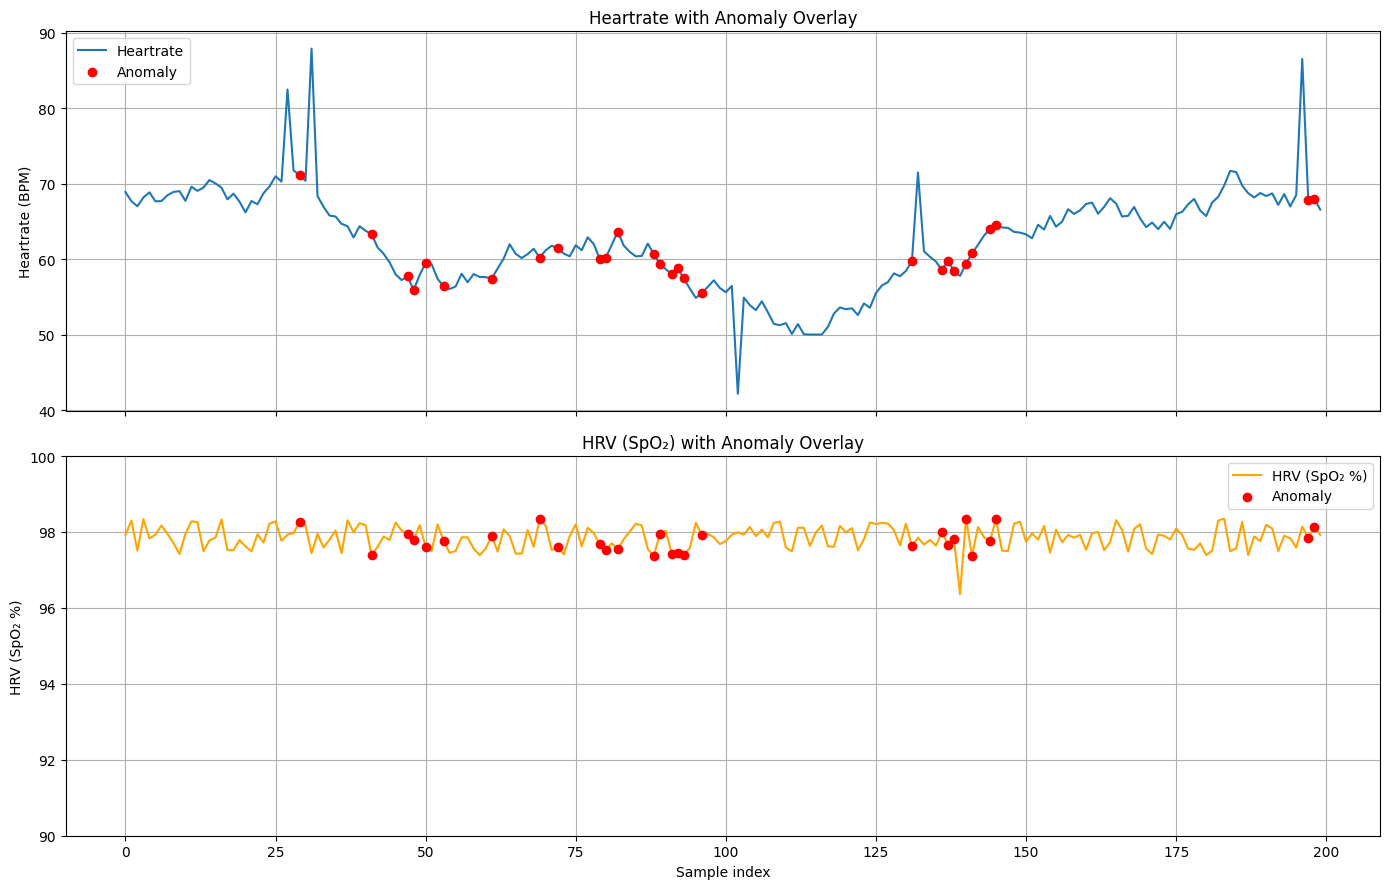

In [ ]:
 # --------------------------------------------------------------
#  Anomaly detection – HeartRate + HRV (SpO₂)
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# ------------------------------------------------------------------
# 1. Load model & data
# ------------------------------------------------------------------
model = load_model("lstm_autoencoder.keras")

df = pd.read_csv("HeartRateHRVtesting.csv")

required = {"Heartrate", "HRV"}
if not required.issubset(df.columns):
    raise ValueError(f"CSV must contain {required}. Found: {list(df.columns)}")

data = df[["Heartrate", "HRV"]].values.astype(np.float32)

# ------------------------------------------------------------------
# 2. Sliding-window → (samples, 4, 2)
# ------------------------------------------------------------------
WINDOW_SIZE = 4

def sliding_windows(arr, win):
    n = len(arr) - win + 1
    if n <= 0:
        raise ValueError("Dataset shorter than window size.")
    return np.stack([arr[i:i + win] for i in range(n)])

X = sliding_windows(data, WINDOW_SIZE)          # shape (samples, 4, 2)

# ------------------------------------------------------------------
# 3. Predict **once** – suppress retracing warning
# ------------------------------------------------------------------
@tf.function(reduce_retracing=True)
def predict_once(x):
    return model(x, training=False)

recon = predict_once(X)                         # same shape as X
recon_np = recon.numpy()                        # convert to NumPy immediately

# ------------------------------------------------------------------
# 4. Reconstruction error (MSE per window)
# ------------------------------------------------------------------
errors = np.mean((X - recon_np) ** 2, axis=(1, 2))   # (samples,)

# ------------------------------------------------------------------
# 5. Adaptive 80th-percentile anomaly detection
# ------------------------------------------------------------------
def detect_anomalies(err, win=100, pct=82):
    anom = []
    for i in range(len(err)):
        lo = max(0, i - win // 2)
        hi = min(len(err), i + win // 2)
        thresh = np.percentile(err[lo:hi], pct)
        if err[i] > thresh:
            anom.append(i)
    print(f"Detected {len(anom)} anomalies (adaptive {pct}th percentile)")
    return anom

anomalies = detect_anomalies(errors)                     # window-space indices
orig_anom_idx = [i + WINDOW_SIZE - 1 for i in anomalies] # original CSV rows

print("Anomaly indices (original CSV rows):", orig_anom_idx)

# ------------------------------------------------------------------
# 6. Build the error series that matches the original DataFrame length
# ------------------------------------------------------------------
#   • one error per window
#   • repeat each error `WINDOW_SIZE` times
#   • trim to exact df length (the first WINDOW_SIZE-1 rows stay NaN)
repeated = np.repeat(errors, WINDOW_SIZE)                # length = samples * 4
error_series = repeated[:len(df)]                         # cut to df length

# ------------------------------------------------------------------
# 7. Safe assignment (no chained-assignment warnings)
# ------------------------------------------------------------------
df = df.copy()                                 # work on a real DataFrame
df["ReconstructionError"] = np.nan
df.loc[WINDOW_SIZE - 1:, "ReconstructionError"] = error_series[WINDOW_SIZE - 1:]

df["Anomaly"] = 0
df.loc[orig_anom_idx, "Anomaly"] = 1

# Save
df.to_csv("HeartRate_Analyzed.csv", index=False)
print("Saved → HeartRate_Analyzed.csv")

# ------------------------------------------------------------------
# 8. Plotting
# ------------------------------------------------------------------
# ---- Reconstruction error ------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(df["ReconstructionError"].iloc[WINDOW_SIZE - 1:],
         label="Reconstruction Error")
plt.axhline(np.percentile(errors, 82), color='r', linestyle='--',
            label="80th-percentile threshold")
plt.scatter(orig_anom_idx,
            df.loc[orig_anom_idx, "ReconstructionError"],
            color='red', zorder=5, label="Anomaly")
plt.title("Reconstruction Error (MSE) – Adaptive Threshold")
plt.xlabel("Sample index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Heartrate + HRV ----------------------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

# Heartrate
axs[0].plot(df["Heartrate"], label="Heartrate")
axs[0].scatter(orig_anom_idx, df.loc[orig_anom_idx, "Heartrate"],
               color='red', zorder=5, label="Anomaly")
axs[0].set_ylabel("Heartrate (BPM)")
axs[0].set_title("Heartrate with Anomaly Overlay")
axs[0].legend()
axs[0].grid(True)

# HRV (SpO₂ %)
axs[1].plot(df["HRV"], label="HRV (SpO₂ %)", color='orange')
axs[1].scatter(orig_anom_idx, df.loc[orig_anom_idx, "HRV"],
               color='red', zorder=5, label="Anomaly")
axs[1].set_xlabel("Sample index")
axs[1].set_ylabel("HRV (SpO₂ %)")
axs[1].set_ylim(90, 100)                     # realistic SpO₂ range
axs[1].set_title("HRV (SpO₂) with Anomaly Overlay")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()